In [244]:
import pandas as pd
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import twitter_samples, stopwords
from nltk.tag import pos_tag
from nltk.tokenize import word_tokenize
from nltk import FreqDist, classify, MaxentClassifier ,NaiveBayesClassifier


df_train_tweets=pd.read_csv('Train.csv')
df_test_tweets=pd.read_csv('Test.csv')
df_submission=pd.read_csv('SampleSubmission.csv')

df_train_tweets.drop(['agreement','tweet_id'],inplace=True,axis=1)

df_train_positif=df_train_tweets[df_train_tweets['label']==1.0].reset_index()
df_train_neutral=df_train_tweets[df_train_tweets['label']==0.0].reset_index()
df_train_negatif=df_train_tweets[df_train_tweets['label']==-1.0].reset_index()

positive_token=[]
negative_token=[]
neutral_token=[]
test_token=[]

for i in  range(len(df_train_positif)):
    positive_token.append(word_tokenize(df_train_positif.safe_text[i]))
for j in  range(len(df_train_negatif)):
    negative_token.append(word_tokenize(df_train_negatif.safe_text[j]))    
for t in  range(len(df_train_neutral)):
    neutral_token.append(word_tokenize(df_train_neutral.safe_text[t]))  
for k in  range(len(df_test_tweets)):
    test_token.append(word_tokenize(str(df_test_tweets.safe_text[k])))   
    
def clean_doc(doc):
	# split into tokens by white space
	tokens = doc.split()
	# remove punctuation from each token
	table = str.maketrans('', '', string.punctuation)
	tokens = [w.translate(table) for w in tokens]
	# remove remaining tokens that are not alphabetic
	tokens = [word for word in tokens if word.isalpha()]
	# filter out stop words
	stop_words = set(stopwords.words('english'))
	tokens = [w for w in tokens if not w in stop_words]
	# filter out short tokens
	tokens = [word for word in tokens if len(word) > 1]
	return tokens

In [245]:
len(df_train_neutral)



4908

In [406]:
import string
from string import punctuation
from os import listdir
from collections import Counter
from nltk.corpus import stopwords

def clean_doc(tokens,vocab):
    # remove punctuation from each token
    table = str.maketrans('', '', string.punctuation)
    # remove remaining tokens that are not alphabetic
    tokens = [word for word in tokens if word.isalpha()]
    # filter out stop words
    stop_words = list(stopwords.words('english'))
    stop_words.extend(['user','url','got','know','think','would','The','people','Is','of','year'])
    tokens = [w for w in tokens if not w in stop_words]
    # filter out short tokens
    tokens = [word for word in tokens if len(word) > 1]
    vocab.update(tokens)
    return tokens

# define vocab
vocab_positive = Counter()
vocab_negative = Counter()
vocab_neutral = Counter()

In [407]:
positive_tokens=[]
negative_tokens=[]
neutral_tokens=[]
test_tokens=[]
for token in positive_token:
    positive_tokens.append(clean_doc(token,vocab_positive))
for token in negative_token:
    negative_tokens.append(clean_doc(token,vocab_negative))
for token in neutral_token:
    neutral_tokens.append(clean_doc(token,vocab_neutral))
#positive_tokens
# add all docs to vocab
# print the size of the vocab
print(len(vocab_positive))
print(len(vocab_negative))
print(len(vocab_neutral))
# print the top words in the vocab
#print(vocab.most_common(50))

8243
3652
10830


In [470]:
# keep tokens with a min occurrence

min_occurane = 10
negative_tokens = [k for k,c in vocab_negative.items() if c >= min_occurane*2]
positive_tokens = [k for k,c in vocab_positive.items() if c >= min_occurane]
neutral_tokens = [k for k,c in vocab_neutral.items() if c >= min_occurane]
print(negative_tokens)
print(positive_tokens)
print(neutral_tokens)

['NOT', 'kid', 'CDC', 'risk', 'autism', 'MMR', 'CDCwhistleblower', 'vaccines', 'kids', 'No', 'vaccination', 'via', 'Vaccine', 'This', 'health', 'flu', 'vaccinate', 'Do', 'get', 'Vaccines', 'say', 'shot', 'measles', 'vaccine', 'Measles', 'causes', 'brain', 'Autism', 'cause', 'need', 'shots', 'school', 'It', 'could', 'safe', 'vaccinated', 'amp', 'If', 'My', 'child', 'baby', 'You', 'outbreak', 'children', 'never', 'getting', 'RT', 'Not', 'disease', 'son', 'How', 'truth', 'Why', 'one', 'parents', 'vaccinations', 'mercury']
['autism', 'caused', 'vaccines', 'due', 'World', 'Autism', 'old', 'study', 'health', 'studies', 'Study', 'kids', 'finds', 'link', 'MMR', 'vaccine', 'VACCINATE', 'YOUR', 'FUCKING', 'KIDS', 'everyone', 'measles', 'VaccinateYourKids', 'AIDS', 'created', 'Oregon', 'Health', 'amp', 'Science', 'University', 'may', 'clear', 'virus', 'Getting', 'With', 'Got', 'Vaccine', 'Thank', 'CA', 'parents', 'children', 'support', 'vaccineswork', 'vaccinations', 'via', 'Good', 'article', 'he

In [457]:
from keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer()
# fit the tokenizer on the documents
tokenizer.fit_on_texts(positive_tokens+negative_tokens+neutral_tokens)

In [458]:
# encode training data set
from keras.utils import to_categorical
from numpy import *

Xtrain= tokenizer.texts_to_matrix(positive_token+negative_token+neutral_token, mode='freq')

print(Xtrain.shape)

ytrain = array([0 for _ in range(4053)] + [1 for _ in range(1038)] + [2 for _ in range(4908)])
ytrain = to_categorical(ytrain)
print(ytrain.shape)
ytrain

(9999, 840)
(9999, 3)


array([[1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       ...,
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.]], dtype=float32)

In [460]:

from keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.optimizers import SGD
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Flatten, Dense

n_words = Xtrain.shape[1]
# define network

# define model
model = Sequential()
model.add(Dense(3000, input_dim=n_words, activation='relu', kernel_initializer='he_uniform'))
model.add(Dense(1000, input_dim=n_words, activation='relu'))
model.add(Dense(200, input_dim=n_words, activation='relu'))
model.add(Dense(3, activation='softmax'))
# compile model
opt = SGD(lr=0.01, momentum=0.9)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
# fit model



Train on 9500 samples, validate on 499 samples
Epoch 1/20
9500/9500 [==============================] - 11s 1ms/step - loss: 0.9016 - accuracy: 0.5906 - val_loss: 0.6717 - val_accuracy: 0.6573
Epoch 2/20
9500/9500 [==============================] - 11s 1ms/step - loss: 0.7845 - accuracy: 0.6656 - val_loss: 0.7001 - val_accuracy: 0.6433
Epoch 3/20
9500/9500 [==============================] - 11s 1ms/step - loss: 0.7452 - accuracy: 0.6824 - val_loss: 0.4880 - val_accuracy: 0.7916
Epoch 4/20
9500/9500 [==============================] - 11s 1ms/step - loss: 0.7097 - accuracy: 0.6961 - val_loss: 0.9502 - val_accuracy: 0.5070
Epoch 5/20
9500/9500 [==============================] - 11s 1ms/step - loss: 0.7067 - accuracy: 0.6965 - val_loss: 0.6583 - val_accuracy: 0.6633
Epoch 6/20
9500/9500 [==============================] - 11s 1ms/step - loss: 0.6837 - accuracy: 0.7102 - val_loss: 0.7306 - val_accuracy: 0.6273
Epoch 7/20
9500/9500 [==============================] - 11s 1ms/step - loss: 0.6738

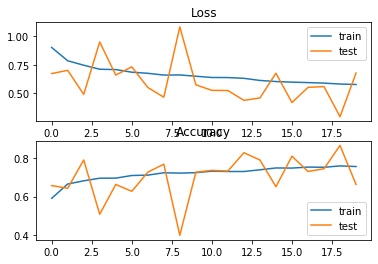

In [461]:
from matplotlib import pyplot
%matplotlib inline
trainx=Xtrain[:9500]
trainy=ytrain[:9500]
testx=Xtrain[9500:]
testy=ytrain[9500:]

history = model.fit(trainx,trainy,validation_data=(testx,testy), epochs=20, verbose=1)

_, train_acc = model.evaluate(trainx, trainy, verbose=0)
_, test_acc = model.evaluate(testx, testy, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))
# plot loss during training
pyplot.subplot(211)
pyplot.title('Loss')
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
# plot accuracy during training
pyplot.subplot(212)
pyplot.title('Accuracy')
pyplot.plot(history.history['accuracy'], label='train')
pyplot.plot(history.history['val_accuracy'], label='test')
pyplot.legend()
pyplot.show()

In [462]:
Xtest= tokenizer.texts_to_matrix(test_token, mode='freq')


In [463]:
res=model.predict(Xtest)
print(res.shape[0])

5177


In [464]:
table=[]
for i in range(res.shape[0]):
    if (res[i][0]>res[i][1] and res[i][0]>res[i][2]):
        table.append(1)
    elif (res[i][1]>res[i][0] and res[i][1]>res[i][2]):
        table.append(-1)
    else:
        table.append(0)

In [465]:
pd.set_option('mode.chained_assignment', None)
for i in range(len(predicted)):
    df_submission.label[i]=float(table[i])

In [466]:
df_submission

,label
tweet_id,
00BHHHP1,1
00UNMD0E,1
01AXPTJF,1
01HOEQJW,1
01JUKMAO,1
01V1X8XW,1
01VCVYR0,0
01VO7KBO,1
020SYHIL,1


In [467]:

df_submission.to_csv('submission2.csv')

In [468]:
table

[1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 -1,
 -1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 -1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 -1,
 -1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 -1,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 -1,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 -1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 -1,
 1,

In [469]:
df_test_tweets.head(10)

,tweet_id,safe_text
0,00BHHHP1,<user> <user> ... &amp; 4 a vaccine given 2 he...
1,00UNMD0E,Students starting school without whooping coug...
2,01AXPTJF,"I'm kinda over every ep of <user> being ""rippe..."
3,01HOEQJW,How many innocent children die for lack of vac...
4,01JUKMAO,"CDC eyeing bird flu vaccine for humans, though..."
5,01V1X8XW,I think that active duty soldiers should get v...
6,01VCVYR0,New Choices For Seasonal Flu Vaccines: WebMD H...
7,01VO7KBO,"As if the vaccination scares weren't enough, t..."
8,020SYHIL,Vaccines are Key to Good Health <url> via <url>
9,02CQIJUI,"Mom: ""do you feel sick in any other way? A fev..."
